## Test AWA Environment/Interface Plugins

In [1]:
from plugins.environments.awa_environment import AWAEnvironment
from plugins.interfaces.test_awa_interface import TestAWAInterface

# import data from csv file
import pandas as pd
variable_file = "plugins/environments/awa_variables.csv"
observable_file = "plugins/environments/awa_observables.csv"
variable_info = pd.read_csv(variable_file).set_index("NAME")
observable_info = pd.read_csv(observable_file).set_index("NAME").T

variables = variable_info[["MIN","MAX"]].T.to_dict()
observables = list(observable_info.keys())

for name in variables:
    variables[name] = [variables[name]["MIN"], variables[name]["MAX"]]
variables

{'AWA:Bira3Ctrl:Ch00': [0.0, 1.0],
 'AWA:Bira2Ctrl:Ch00': [0.0, 1.0],
 'AWA:Drive:DS1:Ctrl': [6.05, 9.07],
 'AWA:Drive:DS3:Ctrl': [0.0, 2.5],
 'AWA:Bira3Ctrl:Ch03': [-0.5, 0.5],
 'AWA:Bira3Ctrl:Ch04': [-0.5, 0.5],
 'AWA:Bira3Ctrl:Ch05': [-0.5, 0.5]}

In [2]:
env = AWAEnvironment(variable_file, observable_file, interface=TestAWAInterface())

In [3]:
env.dict()

{'name': 'awa_environment',
 'interface': {'name': 'awa_interface', 'params': {}, 'x': None, 'y': None},
 'variables': {'AWA:Bira3Ctrl:Ch00': [0.0, 1.0],
  'AWA:Bira2Ctrl:Ch00': [0.0, 1.0],
  'AWA:Drive:DS1:Ctrl': [6.05, 9.07],
  'AWA:Drive:DS3:Ctrl': [0.0, 2.5],
  'AWA:Bira3Ctrl:Ch03': [-0.5, 0.5],
  'AWA:Bira3Ctrl:Ch04': [-0.5, 0.5],
  'AWA:Bira3Ctrl:Ch05': [-0.5, 0.5]},
 'observables': ['13ARV1:ROI1:MinX_RBV',
  '13ARV1:ROI1:MinY_RBV',
  '13ARV1:ROI1:SizeX_RBV',
  '13ARV1:ROI1:SizeY_RBV',
  '13ARV1:Stats1:CentroidX_RBV',
  '13ARV1:Stats1:CentroidY_RBV',
  '13ARV1:Stats1:SigmaX_RBV',
  '13ARV1:Stats1:SigmaY_RBV',
  'AWAICTMon:Ch1',
  'AWAICTMon:Ch2',
  'AWAICTMon:Ch3',
  'AWAICTMon:Ch4',
  'MAX_EXCURSION',
  'TEST:XRMS',
  'TEST:YRMS'],
 'params': {},
 'target_charge_PV': 'AWAICTMon:Ch1',
 'target_charge': None,
 'fractional_charge_deviation': 0.1,
 'roi_pvs': ['13ARV1:ROI1:MinX_RBV',
  '13ARV1:ROI1:MinY_RBV',
  '13ARV1:ROI1:SizeX_RBV',
  '13ARV1:ROI1:SizeY_RBV'],
 'centroid_pvs': ['

In [4]:
env.set_variables({"AWA:Bira3Ctrl:Ch00": 0.5})

In [5]:
env.get_observables(["TEST:XRMS","TEST:YRMS"])

{'TEST:XRMS': 0.5, 'TEST:YRMS': 0.0}

In [6]:
print(env.observables)

['13ARV1:ROI1:MinX_RBV', '13ARV1:ROI1:MinY_RBV', '13ARV1:ROI1:SizeX_RBV', '13ARV1:ROI1:SizeY_RBV', '13ARV1:Stats1:CentroidX_RBV', '13ARV1:Stats1:CentroidY_RBV', '13ARV1:Stats1:SigmaX_RBV', '13ARV1:Stats1:SigmaY_RBV', 'AWAICTMon:Ch1', 'AWAICTMon:Ch2', 'AWAICTMon:Ch3', 'AWAICTMon:Ch4', 'MAX_EXCURSION', 'TEST:XRMS', 'TEST:YRMS']


## Test with Xopt BE

In [7]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.bayesian import BayesianExplorationGenerator

def evaluate(inputs):
    env.set_variables(inputs)
    return env.get_observables(["TEST:XRMS", "TEST:YRMS"])

# remove one variable
variables = dict((name, env.variables[name]) for name in ["AWA:Bira3Ctrl:Ch00"])
vocs = VOCS(variables=variables,
            objectives={"TEST:XRMS":"MINIMIZE"},
            constraints={"TEST:YRMS":["GREATER_THAN",0.0]})
generator = BayesianExplorationGenerator(vocs)
evaluator = Evaluator(function=evaluate)
X = Xopt(vocs=vocs, evaluator=evaluator, generator=generator)

In [8]:
vocs.dict()

{'variables': {'AWA:Bira3Ctrl:Ch00': [0.0, 1.0]},
 'constraints': {'TEST:YRMS': ['GREATER_THAN', 0.0]},
 'objectives': {'TEST:XRMS': 'MINIMIZE'},
 'constants': {},
 'linked_variables': {}}

In [9]:
import pandas as pd
X.evaluate_data(pd.DataFrame({"AWA:Bira3Ctrl:Ch00":[0.0,0.1]}))
X.data

,AWA:Bira3Ctrl:Ch00,TEST:XRMS,TEST:YRMS,xopt_runtime,xopt_error
1,0.0,0.0,0.5,0.000054,False
2,0.1,0.1,0.4,0.000021,False


In [10]:
for i in range(15):
    X.step()

In [21]:
feas_data = X.vocs.feasibility_data(X.data)
train_data = X.data[feas_data["feasible"]]
display(train_data)

,AWA:Bira3Ctrl:Ch00,TEST:XRMS,TEST:YRMS,xopt_runtime,xopt_error
1,0.000000,0.000000,0.500000,0.000054,False
2,0.100000,0.100000,0.400000,0.000021,False
4,0.349659,0.349659,0.150341,0.000056,False
5,0.426169,0.426169,0.073831,0.000068,False
6,0.473511,0.473511,0.026489,0.000047,False
7,0.225065,0.225065,0.274935,0.000048,False
8,0.485931,0.485931,0.014069,0.000047,False
9,0.000000,0.000000,0.500000,0.000058,False
10,0.150059,0.150059,0.349941,0.000056,False
11,0.286676,0.286676,0.213324,0.000054,False


In [22]:
model = X.generator.train_model(train_data)

<Axes: xlabel='AWA:Bira3Ctrl:Ch00'>

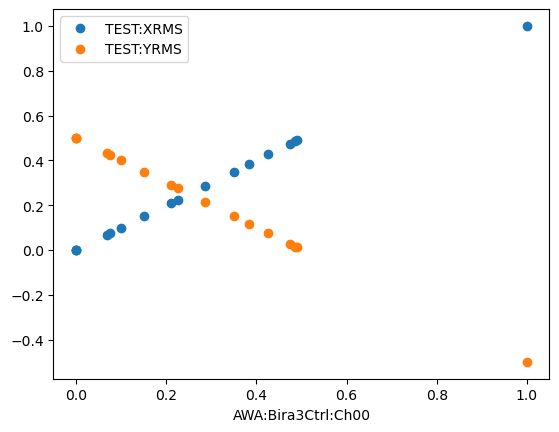

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

X.data.plot(x="AWA:Bira3Ctrl:Ch00", y=["TEST:XRMS","TEST:YRMS"],style="o")

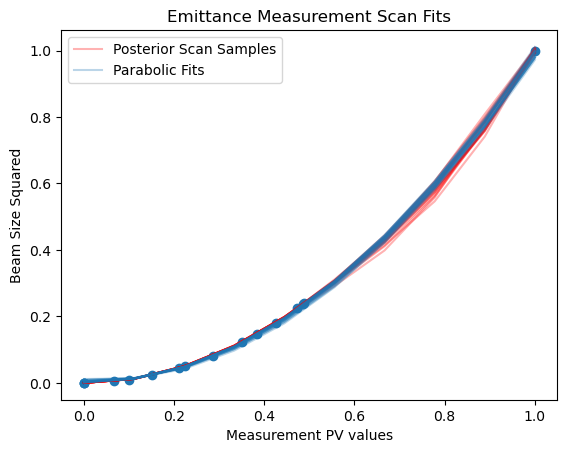

In [15]:
from emitopt.utils import get_valid_emittance_samples
beam_energy = 0.135
q_len = 0.10
distance = 2.6

(emits_at_target_valid,
 emits_sq_at_target,
 is_valid,
 sample_validity_rate) = get_valid_emittance_samples(model.models[0], beam_energy,
                                                     q_len,
                                                     distance, n_samples=50, n_steps_quad_scan=10, visualize=True)